In [3]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import matplotlib as mpl
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_arrays as ua
import datetime
import matplotlib.colors as mcolors
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from utils import u_plot as uplot
import salem
import numpy.ma as ma
from scipy import stats
import warnings
from scipy.ndimage.measurements import label
import shapely.geometry as shpg
import datetime

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [2]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [4]:
fpath = cnst.network_data + 'figs/HUARAZ/'

In [5]:
#corr_all = xr.open_dataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/correlations/GRIDSAT-15_u_correlation_3dRolling_SouthAmerica_1985-2018_diffs.nc')
corr_all = xr.open_dataset('/home/ck/DIR/mymachine/CHIRPS/peru/CHIRPS_u200_correlation_5dRolling_1mm_peruBIG_1985-2018_diffs.nc')
corr_all = corr_all.assign_coords(dayofyear=corr_all.dayofyear.values)
corr_all = corr_all.sel(latitude=slice(-25,0), longitude=slice(-81,-65))

In [6]:
def readERA(var):

    u200orig = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_1981-2019_peru_big.nc')
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [7]:
era = readERA('u200')
era = era.sel(latitude=slice(-25,0), longitude=slice(-81,-65))

In [8]:
m1=9
m2=4

In [9]:
era_BH = era['u'].sel(time=((era['time.year']>=1985)&(era['time.year']<=2018))).groupby('time.month').mean('time')
era_BH_doy = era['u'].sel(time=((era['time.year']>=1985)&(era['time.year']<=2018))).groupby('time.dayofyear').mean('time')

In [10]:
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(-81,-65), lat=slice(-25,0))
topo_on_g = corr_all.salem.lookup_transform(topo)

In [11]:
def find_doy(corr_all, gt_doy=None, lt_doy=None):
    
    if gt_doy is not None:
        mask = corr_all.dayofyear>gt_doy
        pindex = 0
        rcheck = -60  #-60
    if lt_doy is not None:
        mask = corr_all.dayofyear<lt_doy
        pindex = -1
        rcheck = 60 #60
        
    corr = corr_all.sel(dayofyear=mask)
    corr_sig = corr.where(corr['pval']<=0.05)
   
    array = corr_sig['r'].values

    thresh = -0.1
    array[array >= thresh] = 0  # T threshold maskout
    array[np.isnan(array)] = 0  # set ocean nans to 0
    outarr_3 = np.zeros((array.shape[1], array.shape[2]))
    outarr_5 = np.zeros((array.shape[1], array.shape[2]))
    outarr_max = np.zeros((array.shape[1], array.shape[2]))

    for x in range(array.shape[2]):
        for y in range(array.shape[1]):
            
            ts = array[:,y,x]
            labels, numL = label(ts)

            u, inv = np.unique(labels, return_inverse=True)
            n = np.bincount(inv)

            inds_3 = u[(n>=3)&(u!=0)] ## min 3 days onset
            inds_5 = u[(n>=5)&(u!=0)] ## min 5 days breakdown
            

            if len(inds_3)>0:
                pos3 = np.where(labels==inds_3[pindex])
                day3 = ((corr_sig.dayofyear.values+1)[(pos3[0])[pindex]])
            else:
                day3 = np.nan

            if len(inds_5)>0:
                pos5 = np.where(labels==inds_5[pindex])
                day5 = ((corr_sig.dayofyear.values+1)[pos5[0][pindex]])
            else:
                day5 = np.nan

            if (pindex==0) & (np.sum(array[rcheck::,y,x]==0)/abs(rcheck)>0.85):  # remove pixels where more than 40 days in Nov/Dev have no correlation
                day3 = np.nan
                day5 = np.nan
            if (pindex==-1) & (np.sum(array[::rcheck,y,x]==0)/abs(rcheck)>0.85): # remove pixels where more than 40 days in Jan/Feb have no correlation
                day3 = np.nan
                day5 = np.nan

            outarr_3[y,x] = day3
            outarr_5[y,x] = day5
            outarr_max[y,x] = (corr_sig.dayofyear.values+1)[np.argmax(ts)]
            
    outarr_3 = xr.DataArray(outarr_3, coords=[corr['latitude'], corr['longitude']], dims=['latitude','longitude'])
    outarr_5 = xr.DataArray(outarr_5, coords=[corr['latitude'], corr['longitude']], dims=[ 'latitude','longitude'])
            
#     grid = corr.salem.grid.regrid(factor=1)
#     #ipdb.set_trace()
#     outarr_3 = grid.lookup_transform(outarr_3)
#     outarr_5 = grid.lookup_transform(outarr_5)
#     grid = grid.to_dataset()
#     outarr_3 = xr.DataArray(outarr_3, coords=[grid['y'], grid['x']], dims=['latitude','longitude'])
#     outarr_5 = xr.DataArray(outarr_5, coords=[grid['y'], grid['x']], dims=['latitude','longitude'])

    return outarr_3, outarr_5

In [12]:
def find_doy_max(corr_all, start, end):

# 

        
    corr = corr_all#.sel(dayofyear=mask)
    corr_sig = corr.where(corr['pval']<=0.05)
   
    array = corr_sig['r']

    thresh = -0.1
    array.values[array.values >= thresh] = 0  # T threshold maskout
    array.values[np.isnan(array.values)] = 0  # set ocean nans to 0
    
    outarr_max = np.zeros((array.shape[1], array.shape[2]))*np.nan
    corr_max = np.zeros((array.shape[1], array.shape[2]))*np.nan
    

    for x in range(array.shape[2]):
        for y in range(array.shape[1]):
            #ipdb.set_trace()
            ts = array.isel(longitude=x, latitude=y)
            starts = start.values[y,x]
            ends = end.values[y,x]
            
            if np.isnan(starts) | np.isnan(ends):
                continue
            
            #ipdb.set_trace()
            valmax = ts.isel(dayofyear=((ts.dayofyear>starts) | (ts.dayofyear<ends))).rolling(dayofyear=5, min_periods=3, center=True).mean().argmax()
            #ipdb.set_trace()
            doys = (ts.isel(dayofyear=((ts.dayofyear>starts) | (ts.dayofyear<ends))).dayofyear.values+1)[valmax]
            month = datetime.datetime(2017, 1, 1) + pd.Timedelta(str(doys - 1)+' days')
            outarr_max[y,x] = month.month
            corr_max[y,x] = ts.isel(dayofyear=((ts.dayofyear>starts) | (ts.dayofyear<ends)))[valmax]
            
    out_max = xr.DataArray(outarr_max, coords=[corr['latitude'], corr['longitude']], dims=['latitude','longitude'])
    corr_out_max = xr.DataArray(corr_max, coords=[corr['latitude'], corr['longitude']], dims=['latitude','longitude'])

    return out_max, corr_out_max

In [13]:
outarr_3, outarr_5 = find_doy(corr_all, gt_doy=213)  # doy 182 is 1st July
endarr_3, endarr_5= find_doy(corr_all, lt_doy=213)

In [14]:
outmax_gt, corrmax = find_doy_max(corr_all, outarr_3, endarr_5)

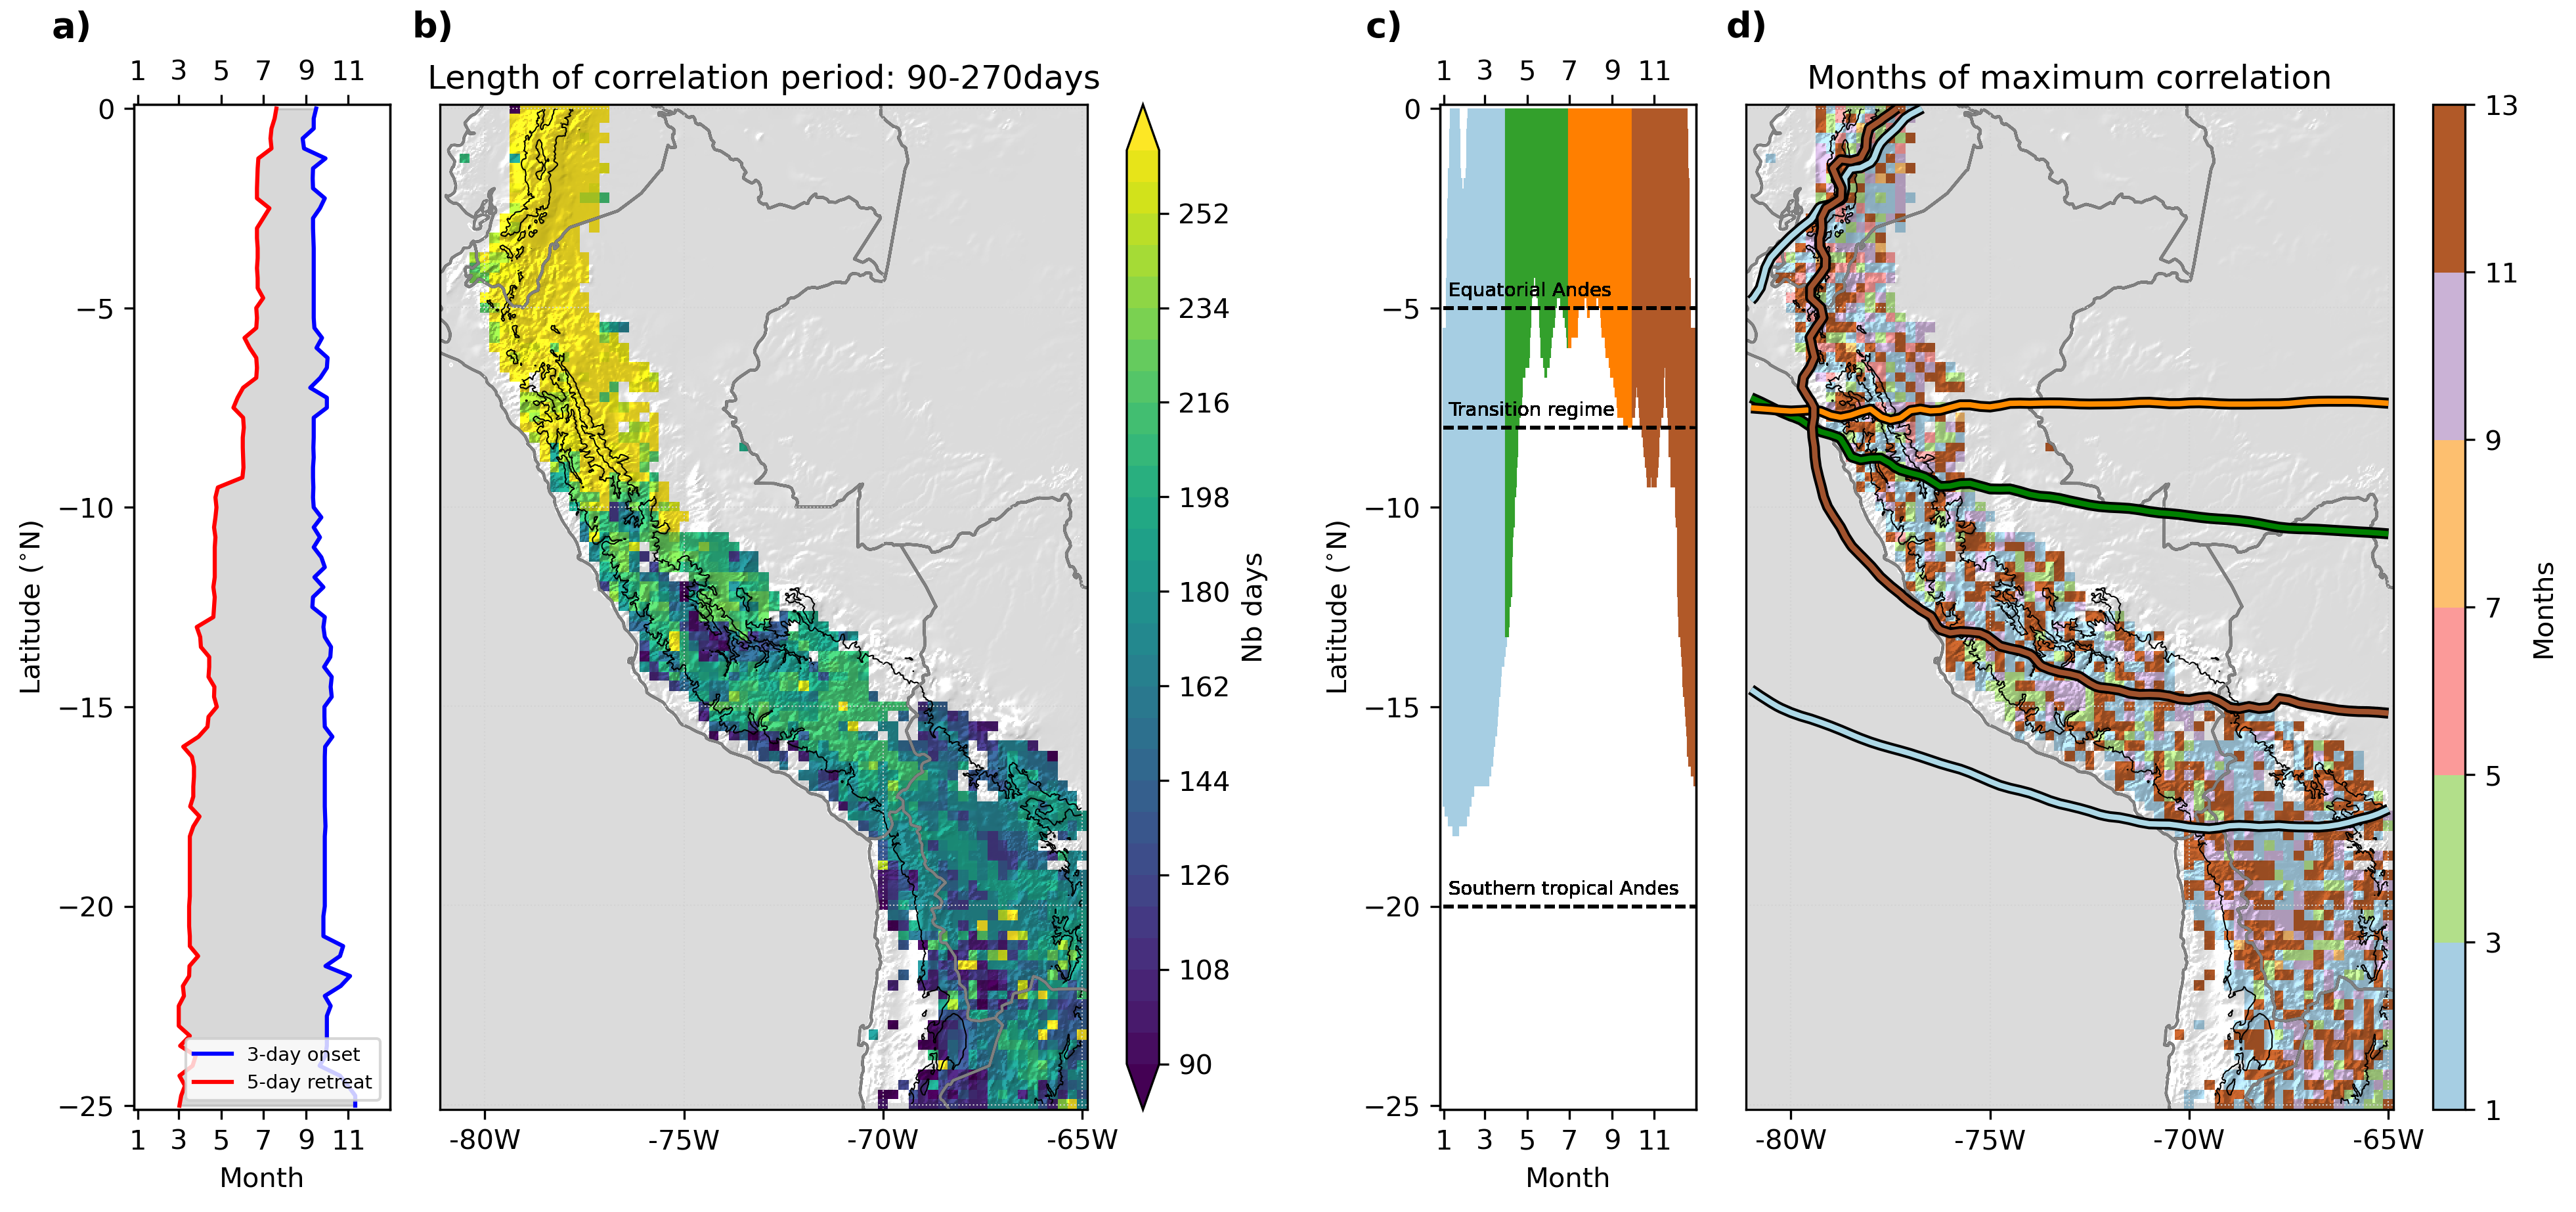

In [15]:
###### lakes = salem.read_shapefile(salem.get_demo_file('ne_50m_lakes.shp'), cached=True)

map = corr_all.salem.get_map()
map.set_shapefile(countries=True, color='grey', linewidths=1)
# Change the lon-lat countour setting
map.set_lonlat_contours(add_ytick_labels=False, interval=5, linewidths=0.5,
                         linestyles='dotted', colors='lightgrey')

#fpath = salem.get_demo_file('hef_srtm.tif')
map.set_topography(topo, relief_factor=1.4)


f = plt.figure(figsize=(13,6), dpi=300)

left, width, width2 = 0.045, 0.4, 0.10#0.345
space=0.003
left2 = left + width + width2 +0.01

bottom, height = 0.07, 0.85


map1 = [left+width2-0.04, bottom, width, height]
line1 = [left, bottom, width2, height]

map2 = [left2+width2-0.04, bottom, width, height]
line2 = [left2, bottom, width2, height]

ax = plt.axes(map1)
endarr_5.values[(topo_on_g<300)]=np.nan # | (endarr_5<65)
season = (365-outarr_3)+endarr_5
map.set_data(season)
map.set_plot_params(levels=np.arange(90,270,6), cmap='viridis', extend='both') #np.arange(90,270,6)
map.set_contour(topo, interp='linear', levels=[0, 3000], cmap='Greys', linewidths=0.5)
map.visualize(cbar_title='Nb days', title='Length of correlation period: 90-270days', orientation='vertical')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax2 = plt.axes(line1)
start=np.nanmedian(outarr_3.values, axis=1)
end = np.nanmedian(endarr_5.values, axis=1)
ax2.plot(start,corr_all.latitude.values, color='b', label='3-day onset')
ax2.plot(end ,corr_all.latitude.values, color='r', label='5-day retreat')
plt.legend(loc='lower right', fontsize=7)
mdays = [1,32,60,91,121,152,182,213,244,274,305,335]
mdays = [1,60,121,182,244,305]
ax2.set_xticks(mdays)
ax2.set_xticklabels(np.arange(1,13,2))
ax2.set_ylim(-25.1,0.1)
ax2.set_xlim(-5,365)
ax2.fill_betweenx(corr_all.latitude.values,end,start, color='grey', alpha=0.3)
ax2.set_xlabel('Month')
ax2.set_ylabel('Latitude ($^{\circ}$N)')
ax22 = ax2.twiny()
ax22.set_xticks(mdays)
ax22.set_xticklabels(np.arange(1,13,2))
ax22.set_ylim(-25.1,0.1)
ax22.set_xlim(-5,365)


ax4 = plt.axes(map2)
import seaborn as sns
colord = sns.color_palette("Paired",as_cmap=True)
colore = sns.color_palette("Paired")


season = outmax_gt

season.values[(topo_on_g<300)]=np.nan # | (endarr_5<65)
#season = (365-outarr_3)+endarr_5
map.set_data(season)
map.set_plot_params(levels=[1,3,5,7,9,11,13], cmap=colord) #np.arange(90,270,6)  [1,4,7,10,13]
map.set_contour(topo, interp='linear', levels=[0, 3000], cmap='Greys', linewidths=0.5)
cb = map.visualize(cbar_title='Months', title='Months of maximum correlation', orientation='vertical')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ccolors = ['lightblue','lightblue', 'lightblue', 'g','g', 'g', 'darkorange', 'darkorange','darkorange', 'sienna', 'sienna', 'sienna']

#ccolors = ['b','b', 'b', 'g','g', 'g', 'y', 'y','y', 'r', 'r', 'r']
xo, yo = map.grid.transform(era_BH.longitude.values, era_BH.latitude.values,
                                    crs=era_BH.salem.grid.proj)
for ids, eb in enumerate(era_BH):
    #print(ids)
    if ids+1 not in np.array([1,4,9,12]):   #,4,6,7,9,10
        continue
    #print(ids, colord[ids])
    ax4.contour(xo,yo,eb.values, levels=[0], colors='k', linewidths=4)
    ax4.contour(xo,yo,eb.values, levels=[0], colors=ccolors[ids],linewidths=2)
    
    
ax5 = plt.axes(line2)
mdays = [1,32,60,91,121,152,182,213,244,274,305,335]
ccinds = {1:0,2:0,3:0,4:3,5:3,6:3,7:7,8:7,9:7,10:11,11:11,12:11}
for ids, eb in enumerate(era_BH_doy.rolling(dayofyear=15, min_periods=3, center=True).mean()):
    #print(ids)
    #print(ids, colord[ids])
    #ipdb.set_trace()
    date = datetime.datetime(2017, 1, 1) + pd.Timedelta(str(eb.dayofyear.values - 1)+' days')
    #ipdb.set_trace()
    cinds=ccinds[date.month]
    eis = eb.where((topo_on_g>2000)&(eb<0)).mean('longitude')
    lats = eb.latitude[np.isfinite(eis)]
    ax5.vlines(ids+1,np.min(lats),np.max(lats),lw=1, color=colore[cinds]) #mdays[ids]
    
    csfont = {'fontname':'DejaVu Sans'}
    ax5.text(8,-7.7,'Transition regime', fontsize=7, family='sans-serif')
    ax5.hlines(-8,0,365, color='k', linestyle='dashed', linewidth=1)
    ax5.text(8,-4.7,'Equatorial Andes', fontsize=7)
    ax5.hlines(-5,0,365, color='k', linestyle='dashed', linewidth=1)
    ax5.text(8,-19.7,'Southern tropical Andes', fontsize=7)
    ax5.hlines(-20,0,365, color='k', linestyle='dashed', linewidth=1)
    
    
    #ipdb.set_trace()



mdays = [1,60,121,182,244,305]
ax5.set_xticks(mdays)
ax5.set_xticklabels(np.arange(1,13,2))
ax5.set_ylim(-25.1,0.1)
ax5.set_xlim(-5,365)
#ax5.fill_betweenx(corr_all.latitude.values,end,start, color='grey', alpha=0.3)
ax5.set_xlabel('Month')
ax5.set_ylabel('Latitude ($^{\circ}$N)')
ax55 = ax5.twiny()
ax55.set_xticks(mdays)
ax55.set_xticklabels(np.arange(1,13,2))
ax55.set_ylim(-25.1,0.1)
ax55.set_xlim(-5,365)

plt.annotate('a)', xy=(0.02, 0.96), xytext=(0, 4), size=13, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')
plt.annotate('b)', xy=(0.16, 0.96), xytext=(0, 4), size=13, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')
plt.annotate('c)', xy=(0.53, 0.96), xytext=(0, 4), size=13, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')
plt.annotate('d)', xy=(0.67, 0.96), xytext=(0, 4), size=13, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')

#plt.tight_layout()
plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/fig01_CHIRPS.jpg')